In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torchmetrics import MeanSquaredError, MeanAbsoluteError

import optuna

In [2]:
df = pd.read_csv('data/ConcreteStrengthData.csv')

In [3]:
df

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [4]:
class CreateDataset(Dataset):
    def __init__(self, X, y, scaler='StandardScaler'):        
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.scaler = None

        if scaler == 'StandardScaler':
            self.scaler = StandardScaler()
            self.X = self.scaler.fit_transform(self.X)
        elif scaler == 'MinMaxScaler':
            self.scaler = MinMaxScaler()
            self.X = self.scaler.fit_transform(self.X)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)        
        
        return X, y

In [5]:
def train_model_reg(num_epoch, 
                    train_dataloader, test_dataloader, 
                    model, criterion, optimizer,
                    device=None):

    if device is None:
        device = torch.device("cpu")
    
    metrics = defaultdict(list)
    mse = MeanSquaredError().to(device)
    mae = MeanAbsoluteError().to(device)

    for epoch in range(num_epoch):
        model.train()
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        
        for data in train_dataloader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate metrics
            train_loss += loss.item() * inputs.size(0)
            train_mse += mse(outputs.squeeze(), targets.squeeze()).item() * inputs.size(0)
            train_mae += mae(outputs.squeeze(), targets.squeeze()).item() * inputs.size(0)
        
        # Average metrics over the dataset
        train_loss /= len(train_dataloader.dataset)
        train_mse /= len(train_dataloader.dataset)
        train_mae /= len(train_dataloader.dataset)
        
        metrics['train_loss'].append(train_loss)
        metrics['train_mse'].append(train_mse)
        metrics['train_mae'].append(train_mae)
        metrics['train_rmse'].append(np.sqrt(train_mse))
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epoch}] " +
                  f"Train Loss: {train_loss:.4f} " +
                  f"MSE: {train_mse:.4f} " +
                  f"MAE: {train_mae:.4f} " +
                  f"RMSE: {np.sqrt(train_mse):.4f}")
        
        # Eval step
        model.eval()
        test_loss = 0.0
        test_mse = 0.0
        test_mae = 0.0
        
        with torch.no_grad():
            for data in test_dataloader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)
                inputs, targets = inputs.float(), targets.float()
                targets = targets.reshape((targets.shape[0], 1))
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Accumulate metrics
                test_loss += loss.item() * inputs.size(0)
                test_mse += mse(outputs.squeeze(), targets.squeeze()).item() * inputs.size(0)
                test_mae += mae(outputs.squeeze(), targets.squeeze()).item() * inputs.size(0)
        
        # Average metrics over the dataset
        test_loss /= len(test_dataloader.dataset)
        test_mse /= len(test_dataloader.dataset)
        test_mae /= len(test_dataloader.dataset)
        
        metrics['test_loss'].append(test_loss)
        metrics['test_mse'].append(test_mse)
        metrics['test_mae'].append(test_mae)
        metrics['test_rmse'].append(np.sqrt(test_mse))
    
    return dict(metrics), model

In [6]:
def plot_metrics(metrics, metric=None):
    if metric:
        plt.figure(figsize=(10, 6))
        plt.plot(metrics[f"train_{metric}"], label=f"Train {metric}")
        plt.plot(metrics[f"test_{metric}"], label=f"Test {metric}")
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.title(metric)
        plt.legend()
        plt.show()

    else:
        num_metrics = len(metrics) // 2
        cols = 2
        rows = (num_metrics + 1) // cols

        fig, axs = plt.subplots(rows, cols, figsize=(10, 6))
        fig.suptitle('Train/Test Metrics', fontsize=16)
        axs = axs.flatten()

        for i, (key, values) in enumerate(metrics.items()):
            if 'train_' in key:
                metric_name = key.replace('train_', '')
                test_key = f'test_{metric_name}'
                if test_key in metrics:
                    axs[i].plot(values, label=f'Train {metric_name}')
                    axs[i].plot(metrics[test_key], label=f'Test {metric_name}')
                    axs[i].set_title(metric_name.capitalize())
                    axs[i].legend()

        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [7]:
X = df.drop(columns=['Strength'])
y = df['Strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((824, 8), (206, 8), (824,), (206,))

In [8]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=40,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=40,
                              num_workers=0
                             )

In [9]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 64, 512)
    hidden2 = trial.suggest_int("hidden2", 32, hidden1)
    hidden3 = trial.suggest_int("hidden3", 16, hidden2)

    class LinearModel(nn.Module):
        def __init__(self, in_dim, out_dim=1):
            super().__init__()
            self.features = nn.Sequential(
                nn.Linear(in_dim, hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2, hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, out_dim),
            )
        def forward(self, x):
            return self.features(x)

    model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    metrics, _ = train_model_reg(
        num_epoch=20,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        device=torch.device("cpu")
    )

    return metrics['test_mse'][-1]

In [10]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2025-04-23 18:11:26,235] A new study created in memory with name: no-name-50fd86df-1f44-41bf-9c09-e0499ce745c2


Epoch [10/20] Train Loss: 1531.9084 MSE: 1531.9084 MAE: 35.3401 RMSE: 39.1396


[I 2025-04-23 18:11:27,436] Trial 0 finished with value: 1348.4317638804612 and parameters: {'lr': 1.4102885433016613e-05, 'hidden1': 343, 'hidden2': 123, 'hidden3': 121}. Best is trial 0 with value: 1348.4317638804612.


Epoch [20/20] Train Loss: 1398.5868 MSE: 1398.5868 MAE: 33.4461 RMSE: 37.3977
Epoch [10/20] Train Loss: 190.4576 MSE: 190.4576 MAE: 11.1964 RMSE: 13.8006


[I 2025-04-23 18:11:27,951] Trial 1 finished with value: 122.1525650765132 and parameters: {'lr': 0.0004234278768828091, 'hidden1': 432, 'hidden2': 99, 'hidden3': 41}. Best is trial 1 with value: 122.1525650765132.


Epoch [20/20] Train Loss: 133.1146 MSE: 133.1146 MAE: 9.3183 RMSE: 11.5375
Epoch [10/20] Train Loss: 1427.4012 MSE: 1427.4012 MAE: 33.7421 RMSE: 37.7810


[I 2025-04-23 18:11:28,409] Trial 2 finished with value: 552.873287460179 and parameters: {'lr': 0.0001288863192461284, 'hidden1': 72, 'hidden2': 35, 'hidden3': 34}. Best is trial 1 with value: 122.1525650765132.


Epoch [20/20] Train Loss: 640.1746 MSE: 640.1746 MAE: 19.9727 RMSE: 25.3017
Epoch [10/20] Train Loss: 45.2838 MSE: 45.2838 MAE: 5.1529 RMSE: 6.7293


[I 2025-04-23 18:11:28,992] Trial 3 finished with value: 49.204630583235364 and parameters: {'lr': 0.00372024925157954, 'hidden1': 445, 'hidden2': 239, 'hidden3': 156}. Best is trial 3 with value: 49.204630583235364.


Epoch [20/20] Train Loss: 24.8828 MSE: 24.8828 MAE: 3.8083 RMSE: 4.9883
Epoch [10/20] Train Loss: 1502.7377 MSE: 1502.7377 MAE: 34.9274 RMSE: 38.7652


[I 2025-04-23 18:11:29,531] Trial 4 finished with value: 1077.981115841171 and parameters: {'lr': 1.9631349356305172e-05, 'hidden1': 232, 'hidden2': 219, 'hidden3': 181}. Best is trial 3 with value: 49.204630583235364.


Epoch [20/20] Train Loss: 1146.5315 MSE: 1146.5315 MAE: 29.6189 RMSE: 33.8605
Epoch [10/20] Train Loss: 208.1136 MSE: 208.1136 MAE: 11.7160 RMSE: 14.4261


[I 2025-04-23 18:11:30,116] Trial 5 finished with value: 117.56774517170435 and parameters: {'lr': 0.00018816535414621996, 'hidden1': 459, 'hidden2': 256, 'hidden3': 156}. Best is trial 3 with value: 49.204630583235364.


Epoch [20/20] Train Loss: 131.1043 MSE: 131.1043 MAE: 9.2549 RMSE: 11.4501
Epoch [10/20] Train Loss: 1531.3451 MSE: 1531.3451 MAE: 35.3208 RMSE: 39.1324


[I 2025-04-23 18:11:30,634] Trial 6 finished with value: 1374.1526471480583 and parameters: {'lr': 1.5945825901862553e-05, 'hidden1': 230, 'hidden2': 169, 'hidden3': 80}. Best is trial 3 with value: 49.204630583235364.


Epoch [20/20] Train Loss: 1422.6306 MSE: 1422.6306 MAE: 33.7878 RMSE: 37.7178
Epoch [10/20] Train Loss: 974.1735 MSE: 974.1735 MAE: 26.8576 RMSE: 31.2118


[I 2025-04-23 18:11:31,099] Trial 7 finished with value: 183.14691265809884 and parameters: {'lr': 0.0001637409156026329, 'hidden1': 95, 'hidden2': 64, 'hidden3': 43}. Best is trial 3 with value: 49.204630583235364.


Epoch [20/20] Train Loss: 206.7203 MSE: 206.7203 MAE: 11.6409 RMSE: 14.3778
Epoch [10/20] Train Loss: 1543.3404 MSE: 1543.3404 MAE: 35.4891 RMSE: 39.2854


[I 2025-04-23 18:11:31,588] Trial 8 finished with value: 1472.9572279846784 and parameters: {'lr': 1.1585656973549372e-05, 'hidden1': 163, 'hidden2': 113, 'hidden3': 50}. Best is trial 3 with value: 49.204630583235364.


Epoch [20/20] Train Loss: 1515.4978 MSE: 1515.4978 MAE: 35.1008 RMSE: 38.9294
Epoch [10/20] Train Loss: 156.0942 MSE: 156.0942 MAE: 10.1575 RMSE: 12.4938


[I 2025-04-23 18:11:32,109] Trial 9 finished with value: 80.92201418089635 and parameters: {'lr': 0.0008930586381885559, 'hidden1': 388, 'hidden2': 99, 'hidden3': 35}. Best is trial 3 with value: 49.204630583235364.


Epoch [20/20] Train Loss: 75.8163 MSE: 75.8163 MAE: 6.8150 RMSE: 8.7073


In [11]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'lr': 0.00372024925157954, 'hidden1': 445, 'hidden2': 239, 'hidden3': 156}


In [12]:
class Model(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 200),
            torch.nn.ReLU(),
            
            nn.Linear(200, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output
    

model = Model(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)

metrics, model = train_model_reg(num_epoch=20,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    )

Epoch [10/20] Train Loss: 37.5354 MSE: 37.5354 MAE: 4.6493 RMSE: 6.1266
Epoch [20/20] Train Loss: 24.3060 MSE: 24.3060 MAE: 3.7521 RMSE: 4.9301


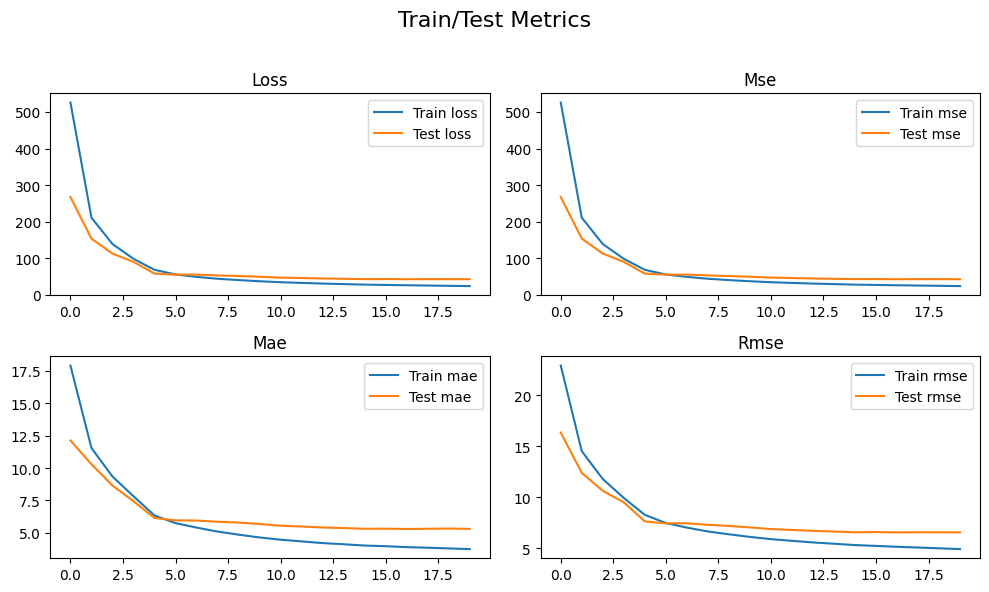

In [13]:
plot_metrics(metrics)

In [14]:
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        predictions = model(X_batch).squeeze()
        
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.8325
MSE: 43.1693
MAE: 5.3100
